# Mapper Lifting Tutorial.

This lifting implements the *Mapper on Graphs* algorithm [\[1\]](https://arxiv.org/pdf/2206.00606) to construct a hypergraph (which can be enriched with the structure of a combinatorial complex) from a graph. It operates in the following way: 

1) Begin with graph $X$ and function $g: X^{(0)} \to [a,b]$. 
2) The algorithm creates $\mathcal{U}$, a cover of $[a,b]$,
3) For $U\in \mathcal{U}$, the set of vertices $g^{-1}(U)$ induce a subgraph $X_U$ of $X$; together, these pullback sets cover $X^{(0)}$. 
4) For each $U$, "cluster" $X_U$ into its connected components. Each connected component is a hyperedge in the lifted topology.
5) Additionally, each edge is a hyperedge in the lifted topology. This could allow for the enrichment of the hypergraph with the structure of a combinatorial complex, if desired. 

The 1-skeleton of the nerve of the resulting cover would give the results of the classic Mapper algorithm for graph simplification with filter function $g$. 

By default, the function $g$ is the first projection of the graph Laplacian embedding of the unweighted edge adjacency matrix of $X$, as this may be defined on all graphs and is known to capture topological information. However, users may define other functions $g$ dependent on what features their data contains. We have implemented some simple examples:

## List of filter functions

The example filter functions $g$ which are implemented are the following: 

1. `"laplacian"` : Converts data to an undirected graph and then applies the
`torch_geometric.transforms.AddLaplacianEigenvectorPE(k=1)` transform and
projects onto the smallest nonzero eigenvector.

2. `"svd"` : Applies the `torch_geometric.transforms.SVDFeatureReduction(out_channels=1)`
transform to the node feature matrix (ie. `torch_geometric.Data.data.x`)
to project data to a 1-dimensional subspace.

3. `"feature_pca"` : Applies `torch.pca_lowrank(q=1)` transform to node feature matrix
(ie. `torch_geometric.Data.data.x`) and then projects to the 1st principal component.

4. `"position_pca"` : Applies `torch.pca_lowrank(q=1)` transform to node position matrix
(ie. `torch_geometric.Data.data.pos`) and then projects to the 1st principal component.

5. `"feature_sum"` : Applies `torch.sum(dim=1)` to the node feature matrix in the graph
(ie. `torch_geometric.Data.data.x`).

6. `"position_sum"` : Applies `torch.sum(dim=1)` to the node position matrix in the graph
(ie. `torch_geometric.Data.data.pos`).


You may also construct your own `filter_attr` and `filter_func`:

7. `"my_filter_attr"` : `my_filter_func = lambda data : my_filter_func(data)`
where `my_filter_func(data)` outputs a `(n_sample, 1)` Tensor.

Additionally, when calling the transform, set 
     `filter_attr = "my_filter_attr"`
     `filter_func = my_filter_func`

## Data Loading

### Imports and utilities

In [1]:
# With this cell any imported module is reloaded before each cell execution
%load_ext autoreload
%autoreload 2


from modules.data.load.loaders import GraphLoader
from modules.data.preprocess.preprocessor import PreProcessor
from modules.utils.utils import (
    describe_data,
    load_dataset_config,
    load_model_config,
    load_transform_config,
)

### Loading Dataset

We visualize the results of Mapper on Graphs on the ZINC dataset, which has a sufficient number of nodes in each graph to see a meaningful and interesting Mapper Lifting.

In [2]:
dataset_name = "ZINC"
dataset_config = load_dataset_config(dataset_name)
loader = GraphLoader(dataset_config)


Dataset configuration for ZINC:

{'data_domain': 'graph',
 'data_type': 'ZINC',
 'data_name': 'ZINC',
 'data_dir': 'datasets/graph/ZINC',
 'num_features': 1,
 'num_classes': 1,
 'task': 'regression',
 'loss_type': 'mse',
 'monitor_metric': 'mae',
 'task_level': 'graph'}


Extracting /home/hfriz/challenge-icml-2024/datasets/graph/ZINC/molecules.zip
Processing...
Processing test dataset: 100%|████████████████████████████████████████| 1000/1000 [00:00<00:00, 4099.46it/s]
Done!



Dataset contains 12000 samples.

Providing more details about sample 0/12000:


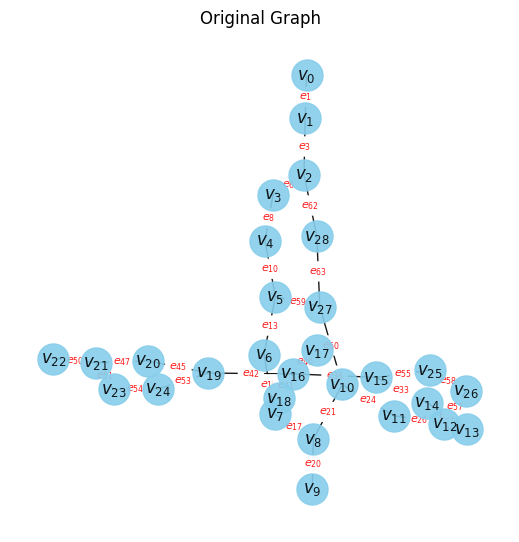

 - Graph with 29 vertices and 64 edges.
 - Features dimensions: [1, 1]
 - There are 0 isolated nodes.



In [3]:
dataset = loader.load()
describe_data(dataset)

## Loading and Applying Lifting

In [4]:
# Define transformation type and id
transform_type = "liftings"
transform_id = "graph2hypergraph/mapper_lifting"

# Read yaml file
transform_config = {"lifting": load_transform_config(transform_type, transform_id)}


Transform configuration for graph2hypergraph/mapper_lifting:

{'transform_type': 'lifting',
 'transform_name': 'MapperLifting',
 'filter_attr': 'laplacian',
 'resolution': 10,
 'gain': 0.3,
 'filter_func': None}


In [5]:
# apply preprocessor to obtain lifted dataset on some of the original graphs

lifted_dataset = PreProcessor(dataset[0:5], transform_config, loader.data_dir)

Processing...
Done!


### Visualize the lifted dataset

The incidence hyperedges include both original edges and clusters from new edges. As the first $n_{edges}$ hyperedges are from the original graph edges, we visualize membership in the remaining hyperedges via node coloring. 

In [7]:
# imports for visualization

import matplotlib.pyplot as plt
import networkx as nx
import torch
from matplotlib.pyplot import Line2D
from torch_geometric.utils import to_networkx

Text(0.5, 0.98, 'Hypergraph constructed from Mapper lifting using default parameters.')

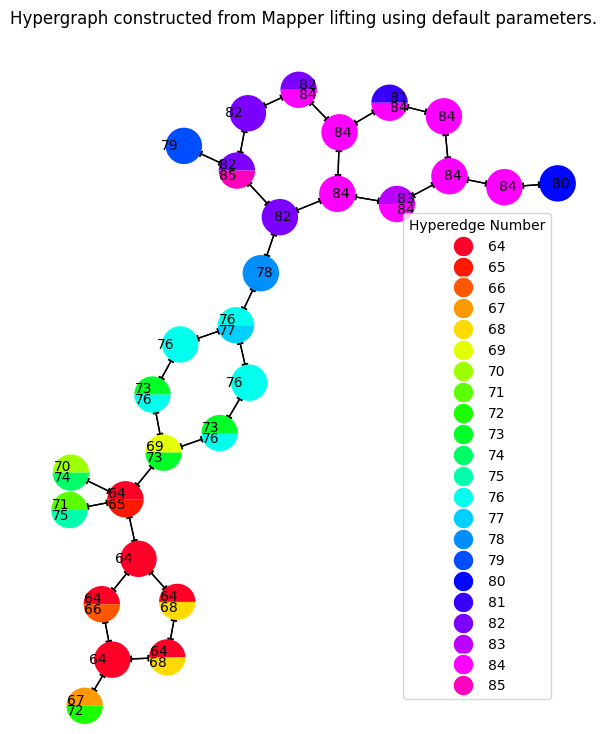

In [8]:
# obtain a representative graph from the lifted dataset
data = lifted_dataset[0]

# set up plot
fig, ax = plt.subplots()
cmap = plt.cm.gist_rainbow

# get a nice layout for the original graph
G = to_networkx(data)
pos = nx.kamada_kawai_layout(G)
_ = nx.draw_networkx_edges(G, pos=pos, ax=ax)

# get the number of original edges
n_edges = data["edge_index"][0].size()[0]

# obtain incidence hyperedges and which vertices belong to the new hyperedges
incidence_hyperedges = data["incidence_hyperedges"].to_dense()
members = torch.where(incidence_hyperedges[:, n_edges:])

# scale colormapping
cmap_max = torch.max(members[1])

# plot pie chart showing hyperedge containment of each node
for node in pos:
    which_hyperedges = torch.where(members[0] == node)[0]

    p, t = ax.pie(
        [1] * len(which_hyperedges),
        center=pos[node],
        colors=cmap(members[1][which_hyperedges] / cmap_max),
        radius=0.05,
        labels=[m.item() for m in members[1][which_hyperedges] + n_edges],
        labeldistance=0.3,
    )

# rescale for visualization purposes
ax.set_xlim(min([pos[node][0] for node in pos]), max([pos[node][0] for node in pos]))
ax.set_ylim(min([pos[node][1] for node in pos]), max([pos[node][1] for node in pos]))

# plot legend
legend_dots = [
    Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        markerfacecolor=cmap(member / cmap_max),
        markersize=15,
        label=f"{member + n_edges}",
    )
    for member in members[1].unique()
]

ax.legend(handles=legend_dots, loc="best", title="Hyperedge Number")

fig.suptitle("Hypergraph constructed from Mapper lifting using default parameters.")

## Creating and Running NN model.

We load an appropriate model and evaluate it on the lifted dataset. If the model evaluates, we have a successful lifting to the hypergraph domain!

In [7]:
from modules.models.hypergraph.unigcn import UniGCNModel

model_type = "hypergraph"
model_id = "unigcn"
model_config = load_model_config(model_type, model_id)

model = UniGCNModel(model_config, dataset_config)


Model configuration for hypergraph UNIGCN:

{'in_channels': None,
 'hidden_channels': 32,
 'out_channels': None,
 'n_layers': 2}


In [8]:
y_hat = model(lifted_dataset.get(0))